# 手順
-----
## 1, 欠損値を数える
## 2, SalePriceがfollowしているdistributionを考える
## 3, 可能なカテゴリごとにダミー変数を作成
## 4,交絡を減らすために相互に無相関な変数を見つける
## 5,独立変数とsale priceを比較して考察
## 6,回帰

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML,display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

train = pd.read_csv("HousePrices_all/train.csv")
test = pd.read_csv("HousePrices_all/test.csv")

quantitative = [f for f in train.columns if train.dtypes[f] != "object"]
quantitative.remove("SalePrice")
quantitative.remove("Id")
qualitative = [f for f in train.columns if train.dtypes[f] == "object"]

Quantitative: 1stFlrSF, 2ndFlrSF, 3SsnPorch, BedroomAbvGr, BsmtFinSF1, BsmtFinSF2, BsmtFullBath, BsmtHalfBath, BsmtUnfSF, EnclosedPorch, Fireplaces, FullBath, GarageArea, GarageCars, GarageYrBlt, GrLivArea, HalfBath, KitchenAbvGr, LotArea, LotFrontage, LowQualFinSF, MSSubClass, MasVnrArea, MiscVal, MoSold, OpenPorchSF, OverallCond, OverallQual, PoolArea, ScreenPorch, TotRmsAbvGrd, TotalBsmtSF, WoodDeckSF, YearBuilt, YearRemodAdd, YrSold

Qualitative: Alley, BldgType, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, CentralAir, Condition1, Condition2, Electrical, ExterCond, ExterQual, Exterior1st, Exterior2nd, Fence, FireplaceQu, Foundation, Functional, GarageCond, GarageFinish, GarageQual, GarageType, Heating, HeatingQC, HouseStyle, KitchenQual, LandContour, LandSlope, LotConfig, LotShape, MSZoning, MasVnrType, MiscFeature, Neighborhood, PavedDrive, PoolQC, RoofMatl, RoofStyle, SaleCondition, SaleType, Street, Utilities

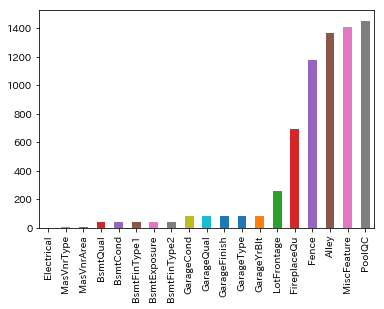

In [7]:
# sort missng of number
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

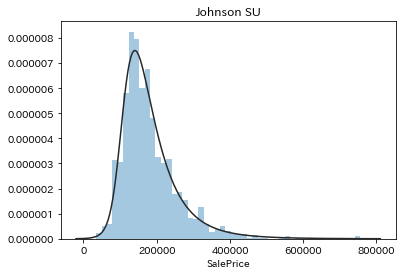

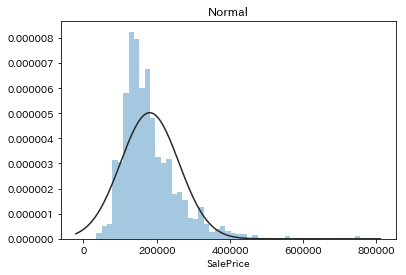

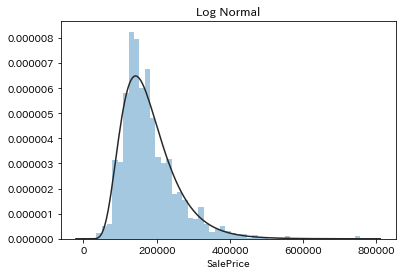

In [8]:
import scipy.stats as st
y = train["SalePrice"]
plt.figure(1); plt.title("Johnson SU")
sns.distplot(y, kde=False, fit = st.johnsonsu)
plt.figure(2); plt.title("Normal")
sns.distplot(y, kde=False, fit = st.norm)
plt.figure(3); plt.title("Log Normal")
sns.distplot(y, kde=False, fit = st.lognorm)

In [9]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


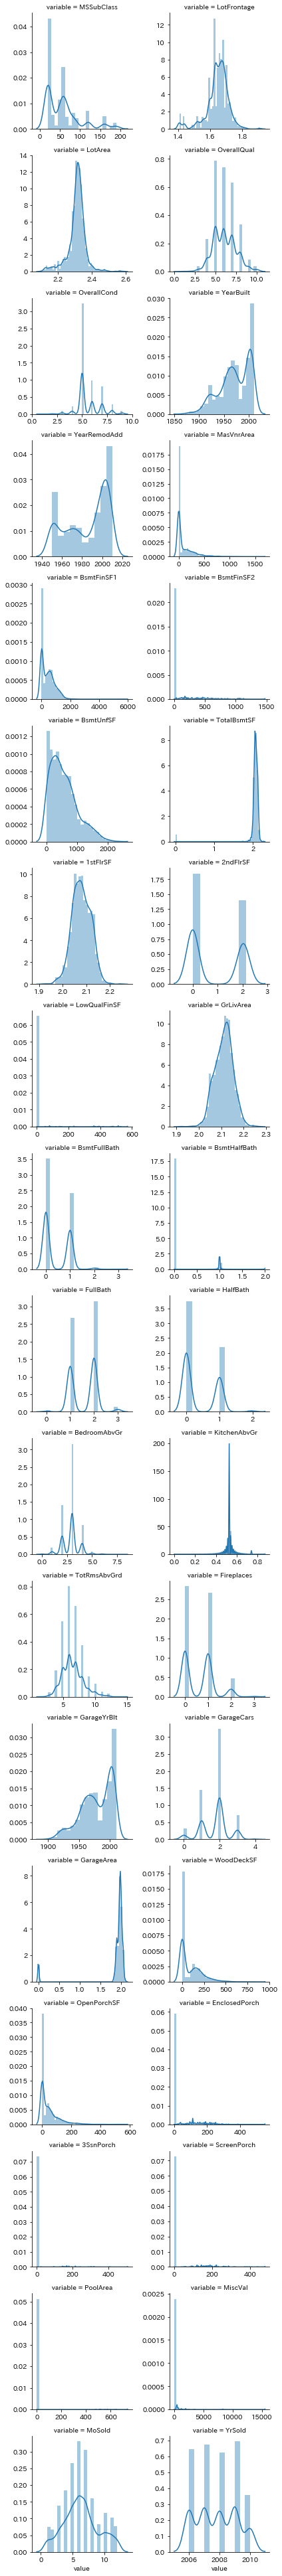

In [10]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

# Categorical data
---
With qualitative variables we can implement two methods. First one is to check distribution of SalePric3 with respect to variable values and enumerate them. Second to create dummy variable for each possible category.

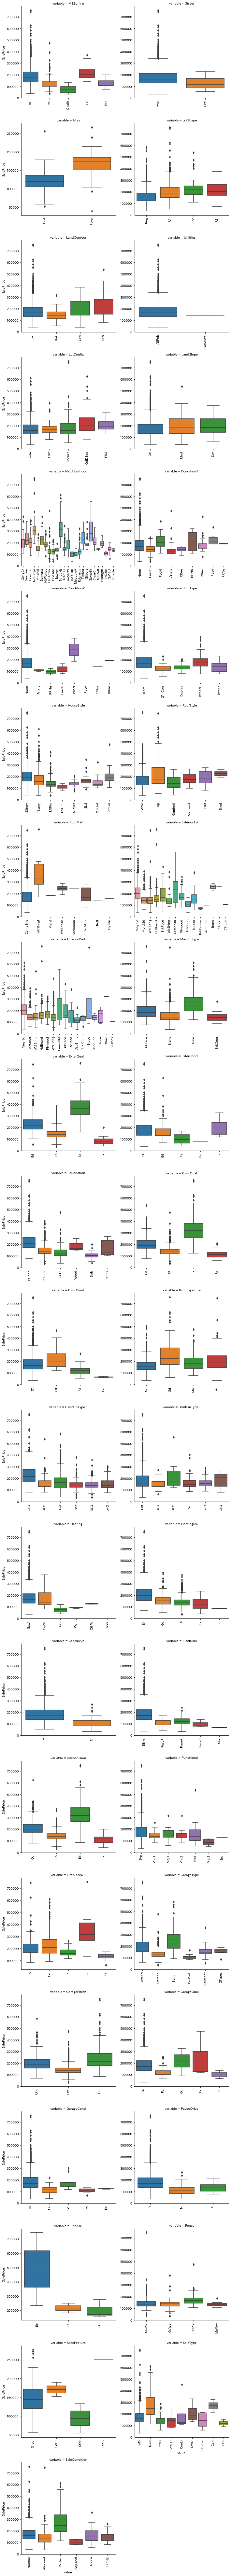

In [11]:
for c in qualitative:
    train[c] = train[c].astype("category")
    
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

C:\Users\hirakata\Anaconda3\lib\site-packages\scipy\stats\stats.py:2916: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


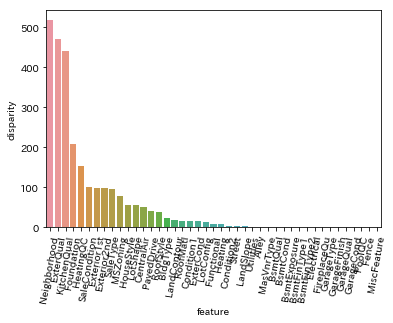

In [12]:
def anova(frame):
    anv = pd.DataFrame()
    anv["feature"] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]["SalePrice"].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv["pval"] = pvals
    return anv.sort_values("pval")

a = anova(train)
a["disparity"] = np.log(1./a["pval"].values)
sns.barplot(data=a, x="feature", y="disparity")
x = plt.xticks(rotation=80)

Here is quick estimation of influence of categorical variable on SalePrice.
For each variable SalePrices are partitioned to distinct sets based on category values. 
Then check with ANOVA test if sets have similar distributions. 
If variable has minor impact then set means should be equal. 
Decreasing pval is sign of increasing diversity in partitions.

In [13]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering["val"] = frame[feature].unique()
    ordering.index = ordering.val
    ordering["spmean"] = frame[[feature, "SalePrice"]].groupby(feature).mean()["SalePrice"]
    ordering = ordering.sort_values("spmean")
    ordering["ordering"] = range(1, ordering.shape[0]+1)
    ordering = ordering["ordering"].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+"_E"] = o

qual_encoded = []
for q in qualitative:
    encode(train, q)
    qual_encoded.append(q+"_E")
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


# Correlations
----
Generally to reduce confounding only variables uncorrelated with each other should be added to regression models

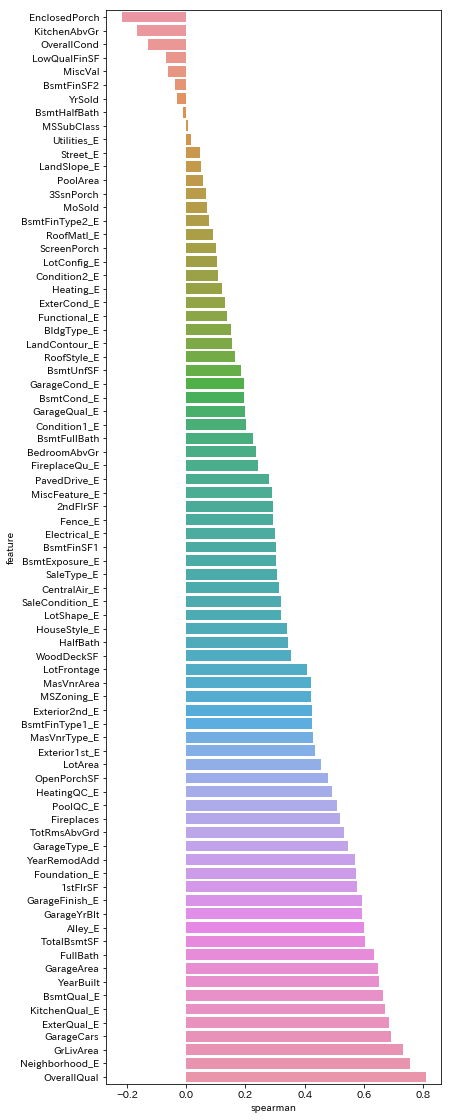

In [14]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr["feature"] = features
    spr["spearman"] = [frame[f].corr(frame["SalePrice"], "spearman") for f in features]
    spr = spr.sort_values("spearman")
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y="feature",x="spearman",orient="h")
    
features = quantitative + qual_encoded
spearman(train,features)

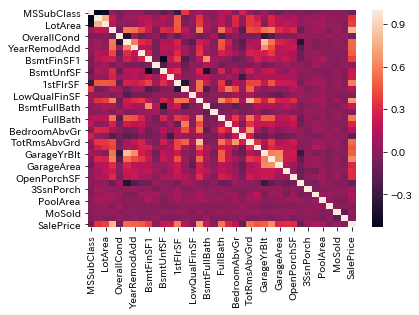

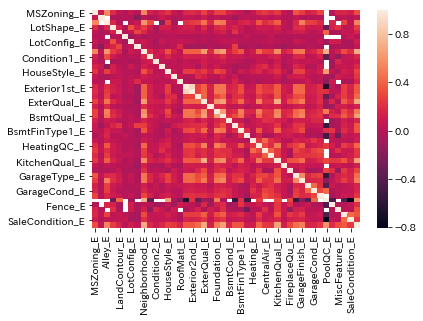

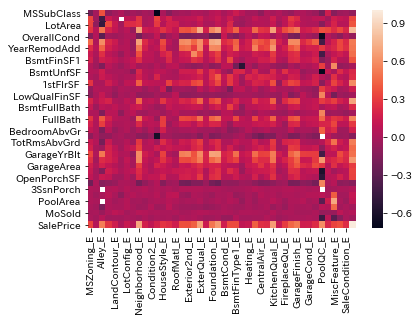

In [15]:
plt.figure(1)
corr = train[quantitative + ["SalePrice"]].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train[qual_encoded + ["SalePrice"]].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1,len(qual_encoded)+1]),
                   index=quantitative+["SalePrice"],columns=qual_encoded+["SalePrice"])
for q1 in quantitative+["SalePrice"]:
    for q2 in qual_encoded+["SalePrice"]:
        corr.loc[q1,q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

# Pairplots
---
It also would be useful to see how sale price compares to each independent variable.

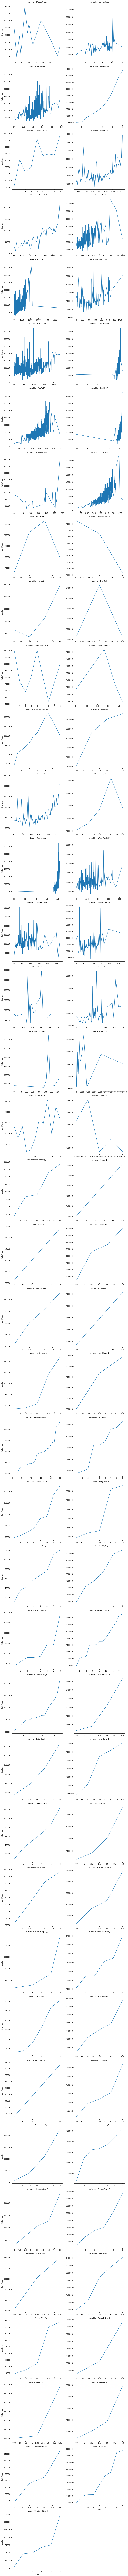

In [16]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({"time":x, "val":y})
    ts = ts.groupby("time").mean()
    ts.plot(ax=ax)

f = pd.melt(train, id_vars=["SalePrice"], value_vars=quantitative+qual_encoded)
g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot,"value","SalePrice")

# Price Segments
----
It is possible that correlations shift with cahge of SlaPrice

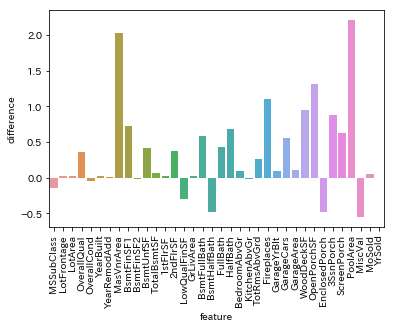

In [17]:
features = quantitative

standard = train[train['SalePrice'] < 200000]
pricey = train[train['SalePrice'] >= 200000]

diff = pd.DataFrame()
diff['feature'] = features

#よくわからない
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean())
                      for f in features]

sns.barplot(data=diff, x='feature', y='difference')
x=plt.xticks(rotation=90)

# Clustering

0.7595002769039816


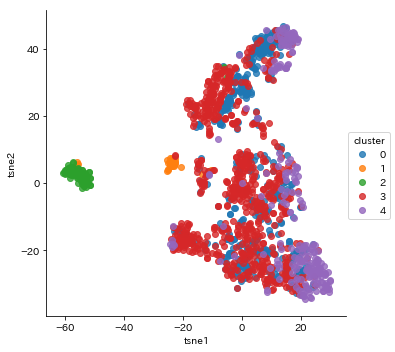

In [18]:
features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters = 5)
kmeans.fit(pc)

fr = pd.DataFrame({"tsne1": tsne[:,0], "tsne2": tsne[:,1], "cluster": kmeans.labels_})
sns.lmplot(data=fr, x="tsne1", y="tsne2", hue="cluster",fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

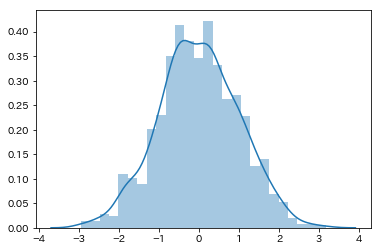

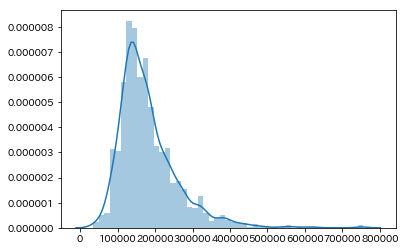

In [19]:
y = train['SalePrice'].values
def johnson(y):
    gamma, eta, epsilon, lbda = stats.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

yt, g, et, ep, l = johnson(y)
yt2 = johnson_inverse(yt, g, et, ep, l)
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2)

# Regression

In [20]:
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    train[feature] = np.log1p(train[feature].values)

def quadratic(feature):
    train[feature+'2'] = train[feature]**2
    
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

quadratic('OverallQual')
quadratic('YearBuilt')
quadratic('YearRemodAdd')
quadratic('TotalBsmtSF')
quadratic('2ndFlrSF')
quadratic('Neighborhood_E')
quadratic('RoofMatl_E')
quadratic('GrLivArea')

qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
        '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']

train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasMasVnr'] = train['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasWoodDeck'] = train['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']


features = quantitative + qual_encoded + boolean + qdr
lasso = linear_model.LassoLarsCV(max_iter=10000)
X = train[features].fillna(0.).values
Y = train['SalePrice'].values
lasso.fit(X, np.log(Y))

Ypred = np.exp(lasso.predict(X))
error(Y, Ypred)

0.11984835024236998

In [24]:
import patsy

Y, X = patsy.dmatrices(
    "SalePrice ~ \
        GarageCars + \
        np.log1p(BsmtFinSF1) + \
        ScreenPorch + \
        Condition1_E + \
        Condition2_E + \
        WoodDeckSF + \
        np.log1p(LotArea) + \
        Foundation_E + \
        MSZoning_E + \
        MasVnrType_E + \
        HouseStyle_E + \
        Fireplaces + \
        CentralAir_E + \
        BsmtFullBath + \
        EnclosedPorch + \
        PavedDrive_E + \
        ExterQual_E + \
        bs(OverallCond, df=7, degree=1) + \
        bs(MSSubClass, df=7, degree=1) + \
        bs(LotArea, df=2, degree=1) + \
        bs(FullBath, df=3, degree=1) + \
        bs(HalfBath, df=2, degree=1) + \
        bs(BsmtFullBath, df=3, degree=1) + \
        bs(TotRmsAbvGrd, df=2, degree=1) + \
        bs(LandSlope_E, df=2, degree=1) + \
        bs(LotConfig_E, df=2, degree=1) + \
        bs(SaleCondition_E, df=3, degree=1) + \
        OverallQual + np.square(OverallQual) + \
        GrLivArea + np.square(GrLivArea) + \
        Q('1stFlrSF') + np.square(Q('1stFlrSF')) + \
        Q('2ndFlrSF') + np.square(Q('2ndFlrSF')) +  \
        TotalBsmtSF + np.square(TotalBsmtSF) +  \
        KitchenAbvGr + np.square(KitchenAbvGr) +  \
        YearBuilt + np.square(YearBuilt) + \
        Neighborhood_E + np.square(Neighborhood_E) + \
        Neighborhood_E:OverallQual + \
        MSSubClass:BldgType_E + \
        ExterQual_E:OverallQual + \
        PoolArea:PoolQC_E + \
        Fireplaces:FireplaceQu_E + \
        OverallQual:KitchenQual_E + \
        GarageQual_E:GarageCond + \
        GarageArea:GarageCars + \
        Q('1stFlrSF'):TotalBsmtSF + \
        TotRmsAbvGrd:GrLivArea",
    train.to_dict('list'))

ridge = linear_model.RidgeCV(cv=10)
ridge.fit(X, np.log(Y))
Ypred = np.exp(ridge.predict(X))
print(error(Y,Ypred))

ValueError: Cannot have number of splits n_splits=10 greater than the number of samples: 7.

# reference
House Prices EDA : https://www.kaggle.com/dgawlik/house-prices-eda